In [1]:
import pandas as pd
import json
import requests
import datetime

In [2]:
#URL found from viewing web inspector in web browser to find the current list of issues
url = "https://seeclickfix.com/api/v2/issues?min_lat=39.03211937423035&min_lng=-95.71889877319336&max_lat=39.052118348329074&max_lng=-95.6312656402588&status=open%2Cacknowledged%2Cclosed&fields%5Bissue%5D=id%2Csummary%2Cdescription%2Cstatus%2Clat%2Clng%2Caddress%2Cmedia%2Ccreated_at%2Cacknowledged_at%2Cclosed_at&page=1"

In [3]:
#grab an initial response to grab the total number of pages
response = requests.get(url).json()
total_pages = response['metadata']['pagination']['pages']

In [4]:
#define a function to get urls from the initial URL 
def get_issues(url):
    #create a temp list for all issues to return
    all_issues = []
    for i in range(1,total_pages +1):
        print(f"getting page {i} of {total_pages}")
        response = requests.get(url).json()
        next_page_url = response['metadata']['pagination']['next_page_url']
        page_issues = response['issues']
        #add current list of issues to the existing list of issues
        all_issues.extend(page_issues)
        #set URL to next page to get the next set of issues
        url = next_page_url
    #return the list of all issues
    return all_issues

In [5]:
# call function to get all issues
all_issues = get_issues(url)

getting page 1 of 10
getting page 2 of 10
getting page 3 of 10
getting page 4 of 10
getting page 5 of 10
getting page 6 of 10
getting page 7 of 10
getting page 8 of 10
getting page 9 of 10
getting page 10 of 10


In [6]:
#create dataframe from issue list
issues_df = pd.DataFrame(all_issues)
#set index to the issues id
issues_df = issues_df.set_index('id')

In [7]:
def clean_summary(df):
    #convert dates
    df['created_at'] = pd.to_datetime(
        df['created_at'], format="%Y/%m/%d", utc=True)
    df['acknowledged_at'] = pd.to_datetime(
        df['acknowledged_at'], format="%Y/%m/%d", utc=True)
    df['closed_at'] = pd.to_datetime(
        df['closed_at'], format="%Y/%m/%d", utc=True)
    # calculate time to acknowledge
    df['time to acknowledge'] = df['acknowledged_at'] - df['created_at']

    #return daframe and replace known errant values
    return df.replace({"Curb and Gutter": "Curb and Gutter Repair",
                       "Junk Yard?": "Property Maintenance & Code Violations",
                       "skatepark light": "safety lighting",
                       "Dead animal on sidewalk ": "Police Animal Control",
                       "Loud pedestrian crossing ": "Street Sign Repair",
                       "Pothole": "Street Repair"})


In [8]:
# call function to clean the summary column
issues_df = clean_summary(issues_df)

In [9]:
status_list = issues_df['status'].value_counts()

In [10]:
summary_list = issues_df['summary'].value_counts()
summary_list

Property Maintenance & Code Violations    58
Curb and Gutter Repair                    43
Street Repair                             18
Alley                                     14
Sidewalk and Ramp                         11
Police General Issue                       8
Trees and Tree Limbs                       8
General Feedback or Questions              5
Other                                      4
Snow or Ice Hazard                         3
Street Sign Repair                         3
safety lighting                            2
Police Animal Control                      2
Utility Work Damage                        2
Graffiti                                   1
Hydrant Leaking                            1
Loud pedestrian crossing                   1
Hole in Buffalo                            1
Downtown Parking General Question          1
dangerous parking                          1
Name: summary, dtype: int64

In [11]:
summary_df = pd.DataFrame(issues_df.groupby('summary')['status'].count())

In [12]:
summary_df.plot(kind="bar")

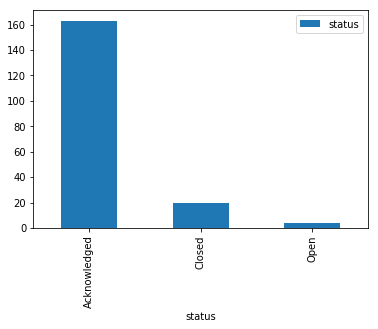

In [13]:
status = pd.DataFrame(issues_df.groupby('status')['status'].count())
status.plot(kind="bar")

In [14]:
issues_df['time to acknowledge']

id
11872529   0 days 00:00:14
11872519   0 days 00:00:09
11872505   0 days 00:00:08
11872484   0 days 00:00:08
11872475   0 days 00:00:05
11867169   0 days 00:00:26
11864430   0 days 00:00:12
11854694   0 days 00:00:14
11852869   0 days 00:00:05
11852838   0 days 00:00:06
11852731   0 days 00:00:05
11852433   0 days 00:00:04
11851623   0 days 00:00:37
11849500   0 days 00:00:03
11847298   0 days 00:00:04
11846696   0 days 00:00:05
11841328   0 days 00:00:07
11837900   0 days 00:00:05
11834635   0 days 00:00:04
11833753   0 days 00:00:17
11831765   0 days 00:00:13
11831592   0 days 00:00:13
11831372   0 days 00:00:04
11831336   0 days 00:00:21
11827220   0 days 00:00:04
11826398   0 days 00:00:09
11826391   0 days 00:00:11
11826385   0 days 00:00:22
11822963   0 days 00:00:04
11817048   0 days 00:00:18
                 ...      
7133880    0 days 00:00:16
7133763    0 days 00:00:04
7030414    0 days 00:00:32
6975346    0 days 00:00:39
6619067    0 days 00:00:23
6585730    0 days 00:00:0

In [15]:
issues_df.groupby('time to acknowledge')['time to acknowledge'].count()

time to acknowledge
0 days 00:00:02       4
0 days 00:00:03       4
0 days 00:00:04      19
0 days 00:00:05      20
0 days 00:00:06       6
0 days 00:00:07      12
0 days 00:00:08       6
0 days 00:00:09       2
0 days 00:00:10       3
0 days 00:00:11       5
0 days 00:00:12       3
0 days 00:00:13       5
0 days 00:00:14       9
0 days 00:00:15       3
0 days 00:00:16       4
0 days 00:00:17       5
0 days 00:00:18       2
0 days 00:00:19       6
0 days 00:00:20       3
0 days 00:00:21       2
0 days 00:00:22       4
0 days 00:00:23       4
0 days 00:00:24       5
0 days 00:00:25       4
0 days 00:00:26       3
0 days 00:00:27       2
0 days 00:00:28       1
0 days 00:00:29       2
0 days 00:00:32       3
0 days 00:00:33       3
0 days 00:00:34       1
0 days 00:00:36       3
0 days 00:00:37       2
0 days 00:00:38       1
0 days 00:00:39       2
0 days 00:00:40       2
0 days 00:00:42       2
0 days 00:00:45       1
0 days 00:00:48       1
0 days 00:01:20       1
0 days 00:01:26     

In [16]:
#pd.to_datetime(issues_df['time to acknowledge'] )